In [187]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import re
import functools 
import operator
#from sklearn.pipeline import make_pipeline, Pipeline

#from sklearn import preprocessing
from sklearn import utils

import datetime
import csv
#import nltk
from sklearn.preprocessing import MultiLabelBinarizer


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

from sklearn.model_selection import train_test_split

In [188]:
# path for the csv files
DATA_PATH = os.path.join(os.getcwd(), 'data')

# loading data to pandas dataframe
def load_data(file_name): 
    file_path = os.path.join(DATA_PATH, file_name) 
    return pd.read_csv(file_path, parse_dates = ['purchase_date', 'release_date'])

def extract_dateinfo(df, col_name):
    year = df[col_name].dt.year
    #month = df[col_name].dt.month
    #day = df[col_name].dt.day
    
    df.loc[:, col_name+'_year'] = year
    #df.loc[:, col_name+'_month'] = month
    #df.loc[:, col_name+'_day'] = day
    return df

#Outlier detection
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    
    outlier_indices = []
    
    for col in features:
        # calculating interquartile range
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR  
        
        # get the indices of outliers for feature col
        outliers_in_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # append the indices to oulier_indices
        outlier_indices.extend(outliers_in_col)
    
    outlier_indices = Counter(outlier_indices)
    result = list(k for k, v in outlier_indices.items() if v > n)
    
    return result

In [189]:
train_set = load_data('train.csv')
test_set = load_data('test.csv')

# Drop outliers from training data
outliers_to_drop = detect_outliers(train_set, 2 ,['price', 'total_positive_reviews', 'total_negative_reviews'])
train_set.loc[outliers_to_drop]
train_set = train_set.drop(outliers_to_drop, axis = 0).reset_index(drop=True)

train_len = train_set.shape[0]
test_len = test_set.shape[0]

# merge training data and testing data 
game_info =  pd.concat(objs=[train_set, test_set], axis=0, sort=False).reset_index(drop=True)
#game_info.drop(columns=['id'], inplace=True)


# check null values
#game_info.fillna(np.nan, inplace=True)

#fill missing purchase date with the most frequent value in purchase_date column
game_info['purchase_date'].fillna(game_info['purchase_date'].mode()[0], inplace=True)


#fille missing number of positive_reviews and negative_reviews with zeros
game_info['total_positive_reviews'].fillna(0.0, inplace=True)
game_info['total_negative_reviews'].fillna(0.0, inplace=True)

#print(game_info.isnull().any().any())
game_info['total_reviews_count'] = game_info['total_positive_reviews'] + game_info['total_negative_reviews']

#transfer boolean values to 1(true) and 0(false)
game_info['is_free'] = game_info['is_free'].map({False: 0.0, True: 1.0})

# extract year value
game_info = extract_dateinfo(game_info, 'purchase_date')
game_info = extract_dateinfo(game_info, 'release_date')
game_info.drop(columns=['purchase_date', 'release_date'], inplace=True)

game_info.drop(columns=['id'], inplace=True)


In [190]:
def process_string(string):
    string = string.lower()
    punctuation = "-"
    
    string = ''.join('' if c.isalpha()==False else c for c in string)
    
    return string
    

In [191]:
# split strings in the categorical columns
game_info['genres'] = game_info['genres'].str.split(',').apply(lambda x: list(map(process_string, x)))
game_info['categories'] = game_info['categories'].str.split(',').apply(lambda x: list(map(process_string, x)))
game_info['tags'] = game_info['tags'].str.split(',').apply(lambda x: list(map(process_string, x)))

In [192]:
#one_and_two = set(genres) + set(categories) - set(genres) 
#unique_tags = one_and_two + set(tags) - one_and_two 

def _unique_tags_(row):
    col1 = row.iloc[0]
    col2 = row.iloc[1]
    col3 = row.iloc[2]
    one_two = set(col1) | set(col2)
    return list(one_two | set(col3))

cate_df = game_info[['genres', 'categories', 'tags']]

game_info.loc[:, 'all_cate'] = cate_df.apply(_unique_tags_, axis=1)
game_info.loc[:, 'cate_count'] = game_info['all_cate'].apply(lambda x: len(x))
game_info.drop(columns=['genres', 'categories', 'tags'], inplace=True)

#cate_df.loc[:, 'genres_count'] = cate_df['genres'].apply(lambda x: len(x))
#cate_df.loc[:, 'cates_count'] = cate_df['categories'].apply(lambda x: len(x))
#cate_df.loc[:, 'tags_count'] = cate_df['tags'].apply(lambda x: len(x))

In [193]:
# doc for new categorization criteria 
cate_list = open('cate_list.txt').read()
new_cate= cate_list.split('\n\n')

# new category names as keys
# content for each category as values
cate_dic = {}
for i in new_cate:
    entry = i.split('\n')
    cate_dic[entry[0]] = entry[1:]

# decide new category for each game
# by comparing tags & categories & genres with new criteria
def decide_new_cate(cate_each_game):
    new_cate = []
    for i in list(cate_dic.keys()):
        if len(set(cate_each_game).intersection(set(cate_dic[i]))) > 0:
            new_cate.append(i)
    return new_cate

new_cate = game_info['all_cate'].apply(decide_new_cate)

one_hot = MultiLabelBinarizer()
new_cate_df = pd.DataFrame(one_hot.fit_transform(new_cate), columns=list(cate_dic.keys()))


In [194]:
cate_df_time = pd.concat([new_cate_df, game_info['playtime_forever']], axis=1, sort=False)


In [195]:
def get_mean_playTime(column):
    temp = cate_df_time.loc[cate_df_time[column.name] > 0]
    
    return temp['playtime_forever'].mean(skipna=True)

mean_play_time = cate_df_time.apply(get_mean_playTime, axis=0)
mean_play_time.drop('playtime_forever', inplace=True)
mean_play_time.sort_values(ascending=False)


sports              8.633333
simulation          4.895175
action-adventure    3.367480
action              3.306136
dtype: float64

In [196]:
#dataframe with only categorical values
cate_df = pd.get_dummies(game_info['all_cate'].apply(pd.Series).stack()).sum(level=0)


cate_df = pd.concat([cate_df, game_info['playtime_forever']], axis=1, sort=False)


#clicker = cate_df.loc[cate_df['clicker'] > 0]

#cols = clicker.columns
#tags = clicker.apply(lambda x: x > 0)
#list(tags.apply(lambda x: list(cols[x.values]), axis=1))

# get_mean_playTime of all game in one specific tag
def get_mean_playTime(column):
    temp = cate_df.loc[cate_df[column.name] > 0]
    
    return temp['playtime_forever'].mean(skipna=True)

mean_play_time = cate_df.apply(get_mean_playTime, axis=0)
mean_play_time.drop('playtime_forever', inplace=True)
mean_play_time.sort_values(ascending=False)

cate_df = cate_df.transpose()
cate_df['count'] = cate_df.astype(bool).sum(axis=1)
cate_df['mean_play_time'] = mean_play_time

cate_df.sort_values('mean_play_time', axis=0, ascending=False, na_position='last').head(30)


,0,1,2,3,4,5,6,7,8,9,...,433,434,435,436,437,438,439,440,count,mean_play_time
clicker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,24.933333
touchfriendly,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,22.237500
battleroyale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,19.979167
rome,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,17.216667
turnbasedcombat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,16.506250
pvp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,16.020370
turnbasedtactics,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,15.438889
teambased,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,14.733333
mouseonly,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,12.910000
partybasedrpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,12.422222


In [197]:
'''
Find the most tags/genres/categories for the 30 longest play games 
'''

temp = cate_df.drop(columns=['count', 'mean_play_time'])
temp = temp.transpose().sort_values('playtime_forever', axis=0, ascending=False, na_position='last').head(200)
temp = temp.drop(columns=['playtime_forever'])
cols = temp.columns
bt = temp.apply(lambda x: x > 0)
cate_list = bt.apply(lambda x: list(cols[x.values]), axis=1)
all_list = list(sum(list(cate_list.values), []))
common_tags = Counter(all_list).most_common(10)

result = list(map(lambda x: x[0], common_tags))
result

['singleplayer',
 'adventure',
 'steamachievements',
 'steamtradingcards',
 'action',
 'indie',
 'steamcloud',
 'atmospheric',
 'greatsoundtrack',
 'rpg']

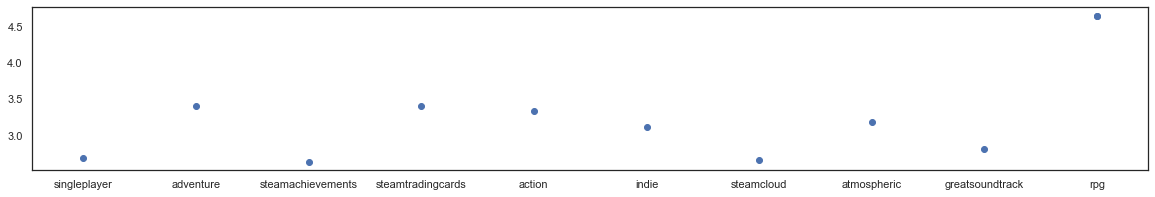

In [198]:
names = result + ['rpg']
values = (list(cate_df.loc[names, 'mean_play_time']))

plt.figure(figsize=(20, 3))
plt.scatter(names, values)
plt.show()

In [199]:
high_corr_features = ['onlinecoop', 'crafting', 'singleplayer']
new_features = cate_df.transpose().drop(['count', 'mean_play_time']).loc[:, high_corr_features]
game_info = pd.concat([game_info, new_cate_df, new_features], axis=1).drop(columns=['all_cate'])


In [200]:
game_info

,playtime_forever,is_free,price,total_positive_reviews,total_negative_reviews,total_reviews_count,purchase_date_year,release_date_year,cate_count,action,action-adventure,simulation,sports,onlinecoop,crafting,singleplayer
0,0.000000,0.0,3700.0,372.0,96.0,468.0,2018,2013,15,0,1,0,0,0.0,0.0,1.0
1,0.016667,1.0,0.0,23.0,0.0,23.0,2016,2015,7,0,1,0,0,0.0,0.0,1.0
2,0.000000,0.0,5000.0,3018.0,663.0,3681.0,2018,2014,23,0,1,0,0,0.0,0.0,1.0
3,1.533333,0.0,9900.0,63078.0,1746.0,64824.0,2016,2010,23,1,1,1,0,0.0,0.0,1.0
4,22.333333,0.0,4800.0,8841.0,523.0,9364.0,2018,2012,25,1,1,1,0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,NaN,0.0,5000.0,9334.0,516.0,9850.0,2018,2013,25,1,1,0,0,0.0,0.0,1.0
437,NaN,0.0,3600.0,1245.0,176.0,1421.0,2018,2009,20,1,1,0,0,0.0,0.0,1.0
438,NaN,0.0,11200.0,33128.0,6350.0,39478.0,2018,2013,25,0,0,1,0,0.0,0.0,1.0
439,NaN,1.0,0.0,5.0,0.0,5.0,2017,2017,16,1,1,1,0,1.0,0.0,1.0


['playtime_forever', 'total_positive_reviews', 'total_negative_reviews', 'total_reviews_count', 'purchase_date_year', 'release_date_year', 'cate_count', 'action', 'action-adventure', 'simulation', 'sports', 'onlinecoop', 'crafting', 'singleplayer']


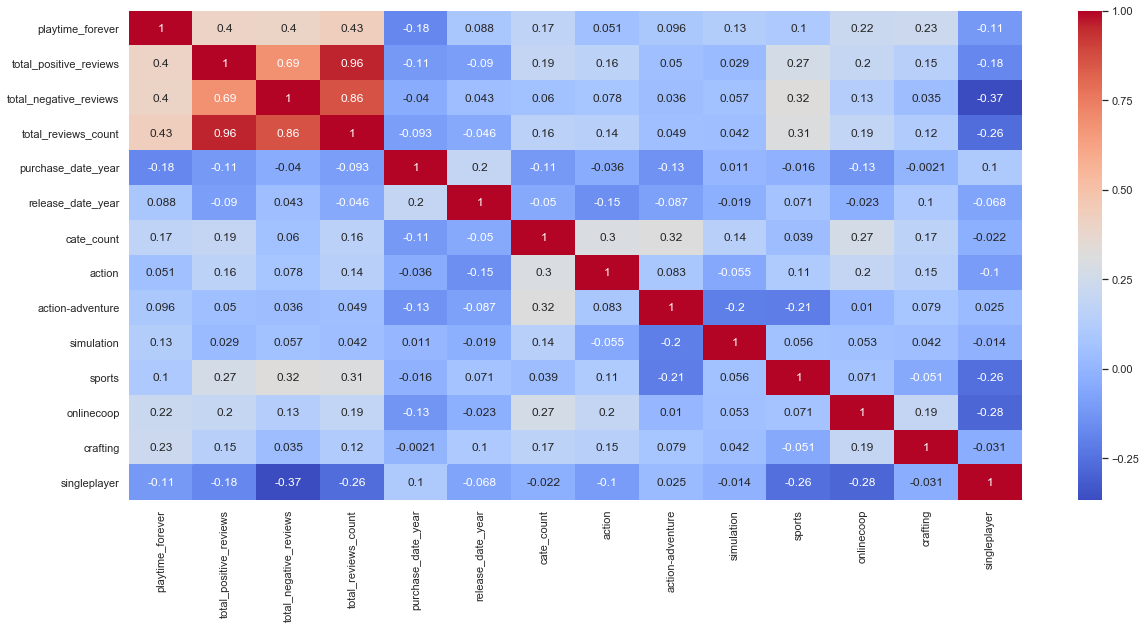

In [201]:
cate = list(game_info.columns)[9:17]
#print(cate)
features = ['playtime_forever', 'total_positive_reviews', 'total_negative_reviews', 'total_reviews_count', 'purchase_date_year', 'release_date_year','cate_count'] + cate
print(features)
plt.figure(figsize=(20, 9))

g = sns.heatmap(game_info[features].corr(),annot=True, cmap = "coolwarm")

In [202]:
# one_hot encoding categorical columns 
#genres_df = pd.get_dummies(cate_df['genres'].apply(pd.Series).stack()).sum(level=0)
#categories_df = pd.get_dummies(cate_df['categories'].apply(pd.Series).stack()).sum(level=0)
#tags_df = pd.get_dummies(cate_df['tags'].apply(pd.Series).stack()).sum(level=0)

# contatenate categorical dataframes with game_info
#game_df = pd.concat([game_info.drop(columns=['genres', 'categories', 'tags']), categories_df, tags_df], axis=1, sort=False)
#game_df = pd.concat([game_df, cate_df.loc[:, ['genres_count','cates_count', 'tags_count']]], axis=1, sort=False)
#game_df

In [203]:
# drop duplicate columns
# game_df = game_df.loc[:, ~game_df.columns.duplicated()]
# genres = list(game_df.columns[6:349])

# print(len(genres))
# with open('genres.txt', 'w') as f:
#     for item in genres:
#         f.write("%s\n" % item)

In [204]:
# correlation < 0.1
small_corr_features = ['is_free', 'action', 'price', 'purchase_date_year', 'action-adventure']
game_info.drop(columns= small_corr_features, inplace=True)

In [205]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

In [206]:
train_data = game_info[:train_len]
test_data = game_info[train_len:]

train_label = train_data['playtime_forever']
train_data = train_data.drop(columns=['playtime_forever'])
test_data.drop(columns=['playtime_forever'],inplace=True)


print('train_data shape: ', train_data.shape)
print('train_label shape: ', train_label.shape)
print('test_data shape : ', test_data.shape)

train_data shape:  (351, 10)
train_label shape:  (351,)
test_data shape :  (90, 10)


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [207]:
train_data.head()

,total_positive_reviews,total_negative_reviews,total_reviews_count,release_date_year,cate_count,simulation,sports,onlinecoop,crafting,singleplayer
0,372.0,96.0,468.0,2013,15,0,0,0.0,0.0,1.0
1,23.0,0.0,23.0,2015,7,0,0,0.0,0.0,1.0
2,3018.0,663.0,3681.0,2014,23,0,0,0.0,0.0,1.0
3,63078.0,1746.0,64824.0,2010,23,1,0,0.0,0.0,1.0
4,8841.0,523.0,9364.0,2012,25,1,0,1.0,0.0,1.0


In [208]:
def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_validation_error(X_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [211]:
# K = 10
# kf = KFold(n_splits=K, shuffle=True, random_state=42)
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]


# empty list to store scores
k_scores = []

def rmse(y_val, y_val_pred):
    return np.sqrt(mean_squared_error(y_val, y_val_pred))
score = make_scorer(rmse, greater_is_better=False)

# 1. we will loop through reasonable values of k
for a in alphas:
    
    model = Ridge(alpha=a, fit_intercept=True, random_state=77, normalize=True)
    # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(model, train_data, train_label, cv=10, scoring=score)
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())

print(k_scores)
#print(list(kf.split(train_data, train_label)))
# for alpha in alphas:
#     train_errors = []
#     validation_errors = []
#     for train_index, val_index in kf.split(train_data, train_label):
        
#         # split data
#         X_train, X_val = train_data.iloc[train_index], train_data.iloc[val_index]
#         y_train, y_val = train_label[train_index], train_label[val_index]

#         # instantiate model
#         model = Ridge(alpha=alpha, fit_intercept=True, random_state=77)
        
#         #calculate errors
#         train_error, val_error = calc_metrics(X_train, y_train, X_val, y_val, model)
        
#         # append to appropriate list
#         train_errors.append(train_error)
#         validation_errors.append(val_error)
    
#     # generate report
#     print('alpha: {:6} | mean(train_error): {:7} | mean(val_error): {}'.
#           format(alpha,
#                  round(np.mean(train_errors),8),
#                  round(np.mean(validation_errors),8)))

[-8.925259812759705, -8.9240562317056, -8.912362799722988, -8.82113167986223, -8.593855891243589, -8.95291203007653]


In [212]:
# scaler = StandardScaler()
# scaler.fit(X_train)
# scaler.transform(X_train)

# def rmse(y_val, y_val_pred):
#     return np.sqrt(mean_squared_error(y_val, y_val_pred))
# score = make_scorer(rmse, greater_is_better=True)

# alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]
# val_errors = []
# for alpha in alphas:
#     ridge = Ridge(alpha=alpha, fit_intercept=False, random_state=77)
#     errors = np.sum(-cross_val_score(ridge, 
#                                      train_data, 
#                                      y=train_label, 
#                                      scoring="neg_mean_squared_error", 
#                                      cv=10))
#     val_errors.append(np.sqrt(errors))

# print(val_errors)

In [213]:
X_train, X_val, y_train, y_val = train_test_split(train_data, train_label, test_size=0.2, random_state=42)

# pca = PCA(n_components=5)
# pca.fit(X_train)
# X_train = pca.transform(X_train)
# X_val = pca.transform(X_val)
# test_data = pca.transform(test_data)

model = Ridge(alpha=0.0001, fit_intercept=True, normalize=True)
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(test_data)

print("Root Mean squared error: ", np.sqrt(mean_squared_error(y_val, y_val_pred)))

Root Mean squared error:  13.257493493539886


In [214]:

result_df = pd.DataFrame(y_test_pred, columns =['playtime_forever']) 
result_df.index.name = 'id'
result_df.to_csv('result.csv')